In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os, json, hashlib, random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix

# 1. Ensure Reproducibility (Industry Requirement)
def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seeds()

# Path to your dataset (Ensure folders: cardboard, glass, metal, paper, plastic, trash)
DATASET_PATH = '/content/drive/MyDrive/AICTEinternship/TrashType_Image_Dataset'

In [4]:
def create_data_manifest(path, version="v1.0"):
    records = []
    print("🔍 Auditing dataset integrity...")
    for category in os.listdir(path):
        cat_path = os.path.join(path, category)
        if not os.path.isdir(cat_path): continue
        for img_name in os.listdir(cat_path):
            img_path = os.path.join(cat_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify() # Check if file is corrupt
                img_hash = hashlib.md5(open(img_path,'rb').read()).hexdigest()
                records.append({'hash': img_hash, 'label': category, 'path': img_path})
            except:
                print(f"🗑️ Removing corrupt file: {img_name}")
                os.remove(img_path)

    df = pd.DataFrame(records)
    df.to_csv(f'manifest_{version}.csv', index=False)
    return df

df_metadata = create_data_manifest(DATASET_PATH)

🔍 Auditing dataset integrity...


Found 2389 images belonging to 6 classes.
Found 594 images belonging to 6 classes.


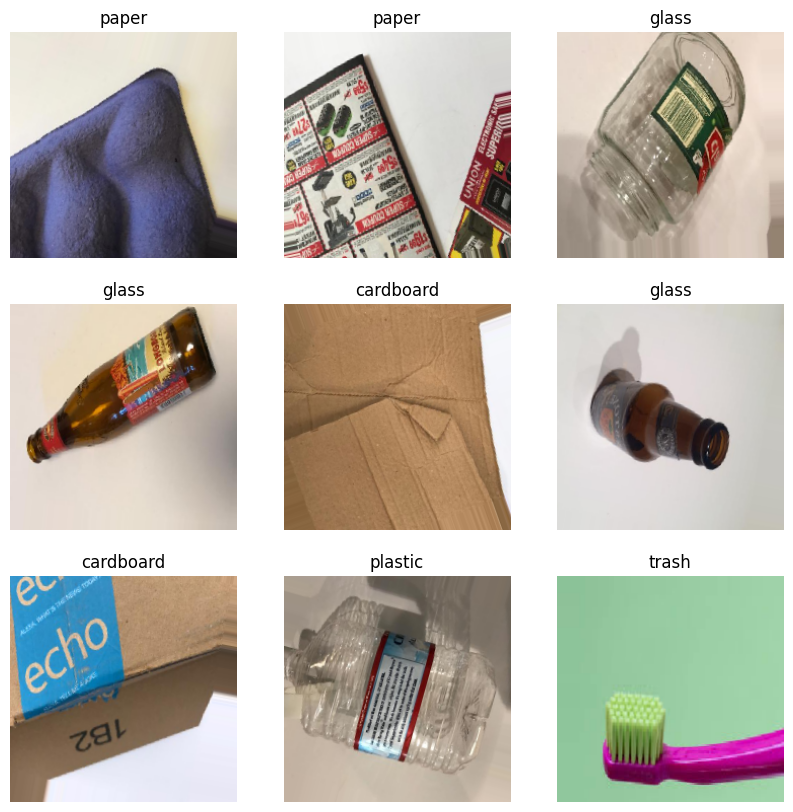

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Use official EfficientNet preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input, # FIX: Replaces 1./255
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    subset='training', class_mode='categorical', seed=42
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    subset='validation', class_mode='categorical', seed=42
)

# Visualize Batch
def show_augmented_batch(gen):
    imgs, labels = next(gen)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        # Note: preprocess_input makes images look weird in plt;
        # this is just for checking if objects are visible.
        plt.imshow(imgs[i].astype('uint8'))
        plt.title(list(gen.class_indices.keys())[np.argmax(labels[i])])
        plt.axis('off')
    plt.show()

show_augmented_batch(train_gen)

In [6]:
# Load Base Model
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet', input_shape=(224, 224, 3)
)
base_model.trainable = False

# Build Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

# Compile with moderate LR for head training
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🚀 Starting Warm-up Phase (Frozen Base)...")
history_warmup = model.fit(
    train_gen, validation_data=val_gen, epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
🚀 Starting Warm-up Phase (Frozen Base)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.4352 - loss: 1.7123 - val_accuracy: 0.7172 - val_loss: 0.8764
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 584ms/step - accuracy: 0.7739 - loss: 0.6300 - val_accuracy: 0.7660 - val_loss: 0.7067
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 577ms/step - accuracy: 0.8413 - loss: 0.4613 - val_accuracy: 0.7694 - val_loss: 0.6889
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 598ms/step - accuracy: 0.8597 - loss: 0.3998 - val_accuracy: 0.7761 - val_loss: 0.6659
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 585ms/step - accuracy: 0.8450 - loss: 0.3975 - val_accuracy: 0.7795 - val_loss: 0.6813
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 581ms/step - accuracy: 0.8691 - loss: 0.3920 - val_accuracy: 0.8030 - val_loss: 0.6238
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 584ms/step - accuracy: 0.8845 - loss: 0.3201 - val_accuracy: 0.7946 - val_loss: 0.6713
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 585ms/step - accuracy: 0.8978 - loss: 0.3252 - val_accura

In [7]:
# Unfreeze the top 20 layers of the base
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a VERY small learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("🚀 Starting Fine-Tuning Phase...")
history_fine = model.fit(
    train_gen, validation_data=val_gen, epochs=15,
    callbacks=[tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)]
)

🚀 Starting Fine-Tuning Phase...
Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 96s 928ms/step - accuracy: 0.8186 - loss: 0.5042 - val_accuracy: 0.8013 - val_loss: 0.6343
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 601ms/step - accuracy: 0.8245 - loss: 0.4487 - val_accuracy: 0.8013 - val_loss: 0.6679
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 52s 695ms/step - accuracy: 0.8502 - loss: 0.4092 - val_accuracy: 0.8081 - val_loss: 0.6310
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 714ms/step - accuracy: 0.8538 - loss: 0.3988 - val_accuracy: 0.8030 - val_loss: 0.6650
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 597ms/step - accuracy: 0.8695 - loss: 0.3872 - val_accuracy: 0.7946 - val_loss: 0.6265
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 621ms/step - accuracy: 0.8784 - loss: 0.3539 - val_accuracy: 0.7896 - val_loss: 0.6622
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 590ms/step - accuracy: 0.8755 - loss: 0.3650 - val_accuracy: 0.7896 - val_loss: 0.6594
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 615ms/step - accuracy: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,784,791 (25.88 MB)

 Trainable params: 1,361,206 (5.19 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

 Optimizer params: 2,722,414 (10.39 MB)

19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 785ms/step
              precision    recall  f1-score   support

   cardboard       0.13      0.14      0.13        80
       glass       0.15      0.17      0.16       100
       metal       0.13      0.15      0.14        82
       paper       0.19      0.22      0.21       118
     plastic       0.12      0.09      0.10        96
       trash       0.25      0.20      0.23       118

    accuracy                           0.17       594
   macro avg       0.16      0.16      0.16       594
weighted avg       0.17      0.17      0.17       594



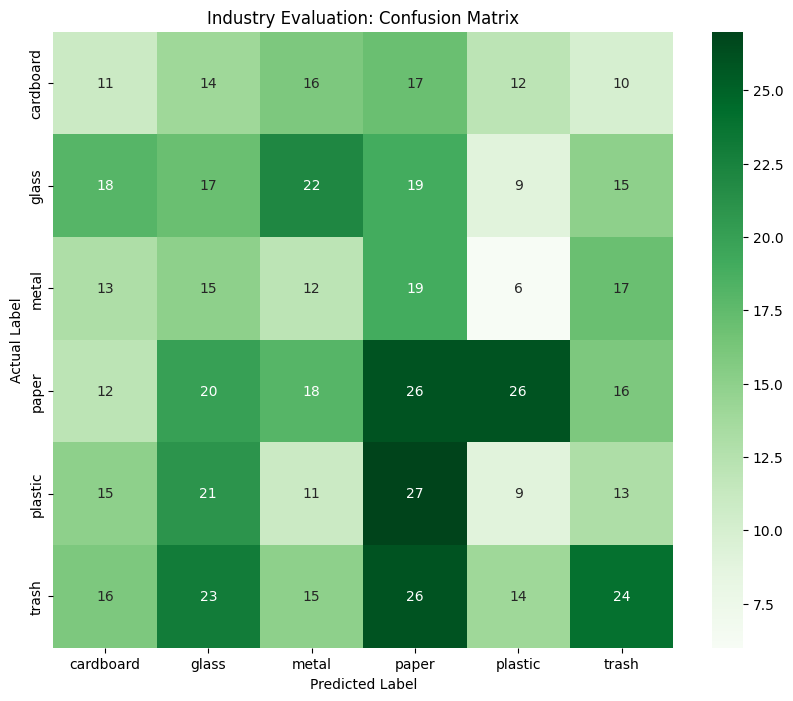

In [8]:
model.summary()
def run_full_eval(model, gen):
    gen.reset()
    predictions = model.predict(gen)
    y_pred = np.argmax(predictions, axis=1)
    y_true = gen.classes
    class_names = list(gen.class_indices.keys())

    # 1. Report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names)
    plt.title("Industry Evaluation: Confusion Matrix")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

run_full_eval(model, val_gen)

📤 Please upload your garbage image:


Saving IMG_20260203_151058_872.jpg to IMG_20260203_151058_872 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


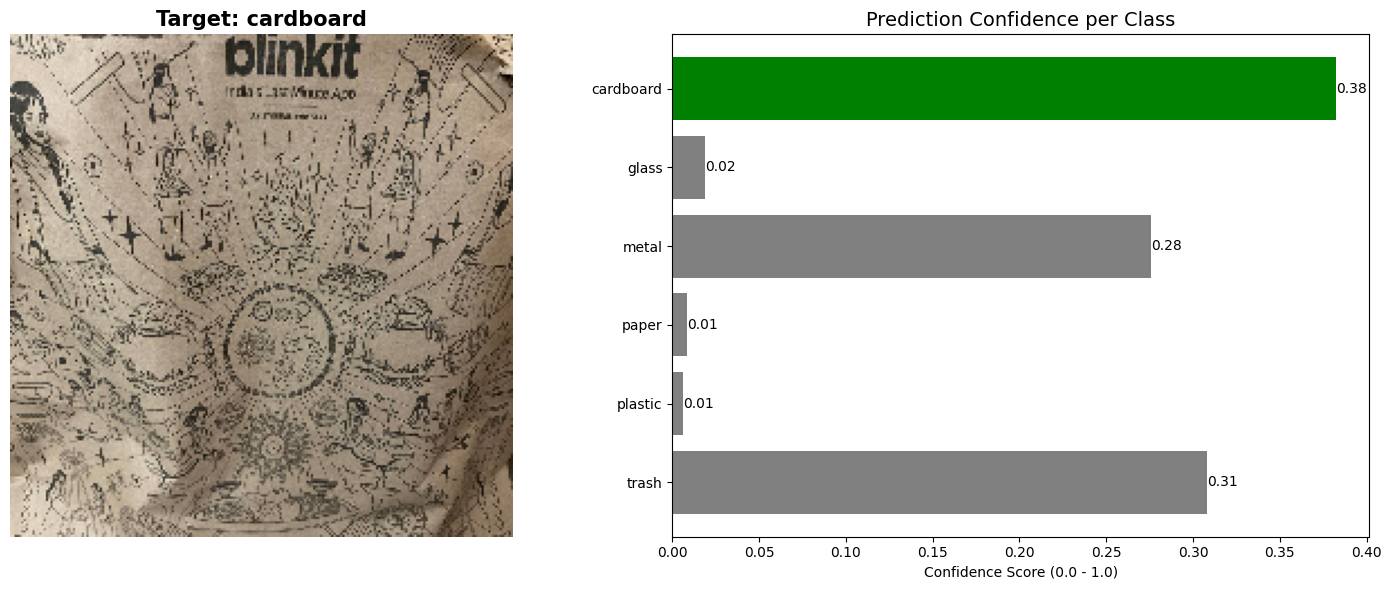

In [15]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt

def test_with_confidence_bar(model, class_indices):
    print("📤 Please upload your garbage image:")
    uploaded = files.upload()

    class_names = list(class_indices.keys())

    for fn in uploaded.keys():
        # 1. Image Preprocessing
        img = image.load_img(fn, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_batch = np.expand_dims(img_array, axis=0)
        img_preprocessed = preprocess_input(img_batch)

        # 2. Get Raw Predictions (Probabilities)
        predictions = model.predict(img_preprocessed)[0]
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]

        # 3. Create Visualization Layout
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Left Side: The Image
        ax1.imshow(img)
        ax1.set_title(f"Target: {predicted_class}", fontsize=15, fontweight='bold')
        ax1.axis('off')

        # Right Side: The Confidence Bar Graph
        y_pos = np.arange(len(class_names))
        colors = ['gray'] * len(class_names)
        colors[predicted_class_idx] = 'green' # Highlight the top prediction in green

        bars = ax2.barh(y_pos, predictions, align='center', color=colors)
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(class_names)
        ax2.invert_yaxis()  # Labels read top-to-bottom
        ax2.set_xlabel('Confidence Score (0.0 - 1.0)')
        ax2.set_title('Prediction Confidence per Class', fontsize=14)

        # Add text labels on bars
        for bar in bars:
            width = bar.get_width()
            ax2.text(width, bar.get_y() + bar.get_height()/2,
                     f'{width:.2f}', va='center', fontsize=10)

        plt.tight_layout()
        plt.show()

# --- EXECUTE ---
test_with_confidence_bar(model, train_gen.class_indices)

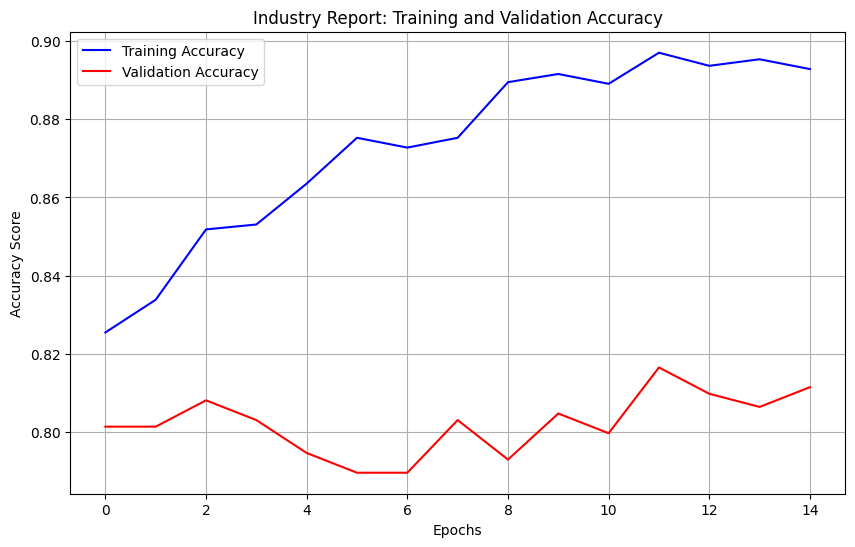

In [17]:
def plot_final_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title('Industry Report: Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_final_results(history_fine)

In [19]:
# 1. Final Save
model.save("garbage_classifier_final.keras")

# 2. Load the 'best' version saved by the ModelCheckpoint callback
checkpoint_path = 'best_model.keras'

if os.path.exists(checkpoint_path):
    final_model = tf.keras.models.load_model(checkpoint_path)
    print("✅ Loaded the absolute best weights from Checkpoint.")
else:
    final_model = model
    print("⚠️ Checkpoint not found, using the weights from the last epoch.")

# 3. Export and Download
export_filename = 'garbage_classifier_model.keras'
final_model.save(export_filename)

from google.colab import files
files.download(export_filename)

print(f"✅ {export_filename} saved and download triggered!")

✅ Loaded the absolute best weights from Checkpoint.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ garbage_classifier_model.keras saved and download triggered!
